In [103]:
#import serial
import time
import socket
#import sys
import json

#import pandas as pd

epochtime = int(time.time())

sock = socket.socket(socket.AF_INET, socket.SOCK_STREAM)
#server_address = ('192.168.1.177', 2048)
server_address = ('192.168.137.50', 2048)
print('connecting to %s port %s' % server_address)
sock.connect(server_address)

#f = open('outputETH.txt','a')
#f = open('outputETHjson.json', 'a')
#f.write('{')
filename='new_out_eth.json'

with open(filename) as json_file:
    json_file = json.load(json_file)

    json_file['time'] = []
    json_file['board'] = []


    epochtime = int(time.time())
    #f.write('"time": ' + str(epochtime) + ',\n')
    #data_time = str(epochtime)
    time_json = json.loads(str(epochtime))
    json_file['time'] = [time_json]

    #
    message = '?'
    sock.sendall(message.encode(encoding='utf-8'))

    time.sleep(1)
    data = sock.recv(512)
    data = data.decode('utf-8')
    data = data[9:]
    data = data[:-1]
    print(data)
    received = json.loads(data)
    json_file['board'] = [received]

with open(filename, 'w') as filename:
    json.dump(json_file, filename)

filename='new_out_eth.json'

with open(filename) as json_file:
    json_file = json.load(json_file)

for x in range (50):
#while True:
    epochtime = int(time.time())
    #f.write('"time": ' + str(epochtime) + ',\n')
    #data_time = str(epochtime)
    time_json = json.loads(str(epochtime))
    json_file['time'].append(time_json)

    #
    message = '?'
    sock.sendall(message.encode(encoding='utf-8'))

    time.sleep(1)
    data = sock.recv(512)
    data = data.decode('utf-8')
    data = data[9:]
    data = data[:-1]
    print(data)
    received = json.loads(data)
    json_file['board'].append(received)
    #f.write(str(data) + ',\n')

print('closing socket')
sock.close()

with open(filename, 'w') as filename:
    json.dump(json_file, filename)
#print ("Received: {}".format(received))

connecting to 192.168.1.177 port 2048
[{"id":0,"voltages":{"CH0":0.006905,"CH1":0.029493,"CH2":0.00181,"CH3":0.01798,"CH4":0.011047,"CH5":0.020605,"CH6":0.010534,"CH7":0.013822,"CH8":-0.002355,"CH9":-0.000294,"CH10":0.001571,"CH11":0.000063,"CH12":-0.007343,"CH13":0.007752,"CH14":-0.002569,"CH15":0.009623}}]
[{"id":0,"voltages":{"CH0":0.006905,"CH1":0.029493,"CH2":0.00181,"CH3":0.01798,"CH4":0.011047,"CH5":0.020605,"CH6":0.010534,"CH7":0.013822,"CH8":-0.002355,"CH9":-0.000294,"CH10":0.001571,"CH11":0.000063,"CH12":-0.007343,"CH13":0.007752,"CH14":-0.002569,"CH15":0.009623}}]
[{"id":0,"voltages":{"CH0":0.005035,"CH1":0.033763,"CH2":-0.000992,"CH3":0.016599,"CH4":0.009046,"CH5":0.02136,"CH6":0.008545,"CH7":0.015279,"CH8":0.000685,"CH9":0.00001,"CH10":-0.000932,"CH11":0.000127,"CH12":-0.004818,"CH13":0.00851,"CH14":-0.002524,"CH15":0.010588}}]
[{"id":0,"voltages":{"CH0":0.005035,"CH1":0.033763,"CH2":-0.000992,"CH3":0.016599,"CH4":0.009046,"CH5":0.02136,"CH6":0.008545,"CH7":0.015279,"CH8":

[1734434194, 1734434195, 1734434196, 1734434197, 1734434198, 1734434199, 1734434200, 1734434201, 1734434202, 1734434203, 1734434204, 1734434205, 1734434206, 1734434207, 1734434208, 1734434209, 1734434210, 1734434211, 1734434212, 1734434213, 1734434214, 1734434215, 1734434216, 1734434217, 1734434218, 1734434219, 1734434220, 1734434221, 1734434222, 1734434223, 1734434224, 1734434225, 1734434226, 1734434227, 1734434228, 1734434229, 1734434230, 1734434231, 1734434232, 1734434233, 1734434234, 1734434235, 1734434236, 1734434237, 1734434238, 1734434239, 1734434240, 1734434241, 1734434242, 1734434243, 1734434244]
[[{'id': 0, 'voltages': {'CH0': 0.006905, 'CH1': 0.029493, 'CH2': 0.00181, 'CH3': 0.01798, 'CH4': 0.011047, 'CH5': 0.020605, 'CH6': 0.010534, 'CH7': 0.013822, 'CH8': -0.002355, 'CH9': -0.000294, 'CH10': 0.001571, 'CH11': 6.3e-05, 'CH12': -0.007343, 'CH13': 0.007752, 'CH14': -0.002569, 'CH15': 0.009623}}], [{'id': 0, 'voltages': {'CH0': 0.006905, 'CH1': 0.029493, 'CH2': 0.00181, 'CH3':

<Axes: >

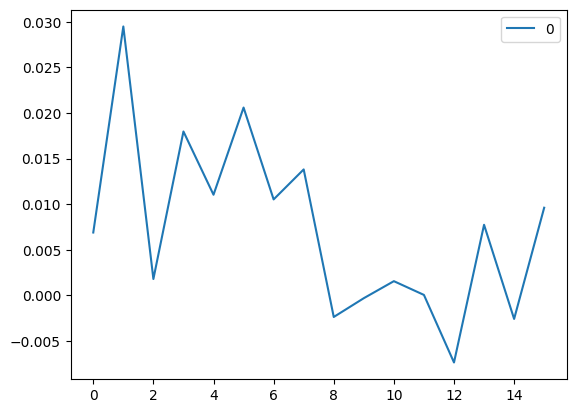

In [4]:
import pandas as pd

# d = {"sell": [
#            {
#                "Rate": 0.001425,
#                "Quantity": 537.27713514
#            },
#            {
#                "Rate": 0.00142853,
#                "Quantity": 6.59174681
#            }
# ]}

#jsonFile = open('outputETH.txt', 'r')
import json

with open('new_out_eth.json') as json_file:
    json_decoded = json.load(json_file)

#keys =json_decoded.keys()
print(json_decoded['time'])
print(json_decoded['board'])
print(json_decoded['board'][0])
print(json_decoded['board'][0][0])
print(json_decoded['board'][0][0]['voltages']['CH0'])


for x in range(0,2):
    print(json_decoded['board'][x][0]['voltages']['CH0'])


df = pd.DataFrame(json_decoded['board'][0][0]['voltages'].values())
#df['board']
dff = df
#print(json_decoded['board'][0]['id'])
for i in range(0, 1):

    dff[i] = json_decoded['board'][i][0]['voltages'].values()
    #dff = df.append(i = json_decoded['board'][i][0]['voltages'].values())
    #pd.json_normalize(df)

    print (df)
    print (dff)
#      Quantity      Rate
# 0  537.277135  0.001425
# 1    6.591747  0.001429

df.plot()
dff.plot()